In [1]:
import torch
import pandas as pd 
from spender.data.sdss import BOSS
import matplotlib.pyplot as plt
#import smplotlib
import os 
import numpy as np
from astropy.io import fits 

github = "pmelchior/spender"
sdss, model = torch.hub.load(github, 'sdss_II', map_location=torch.device('cpu'))

plates = []
mjds = []
fiberids = []

waves = []
fluxes = []

dir = '/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra'
for sub_dir in os.listdir(dir)[0:2]: 
    if '.' not in sub_dir:
        sub_dir = os.path.join(dir, sub_dir)
        for file in os.listdir(sub_dir): 
            if '.1' not in file: 
                file_list = file.split('-')
                plates.append(int(file_list[1]))
                mjds.append(int(file_list[2]))
                fiberids.append(int(file_list[3].split('.')[0]))

                hdul = fits.open(os.path.join(sub_dir, file))

                #for i in hdul[1].header.values():
                waves.append(10**hdul[1].data['loglam'])
                fluxes.append(hdul[1].data['model']) # flux is raw, model is smoothed

fluxes = [i/np.median(i) for i in fluxes]

ids = list((plates[i], mjds[i], fiberids[i]) for i in range(len(waves)))

spec, w, z, norm, zerr = BOSS.make_batch(dir, ids)

with torch.no_grad():
    s, spec_rest, spec_reco = model._forward(spec, instrument=sdss, z=z)

spec = spec.numpy()

wave_obs = BOSS._wave_obs.numpy()
spec_reco = spec_reco.numpy()

Using cache found in /Users/yaroslav/.cache/torch/hub/pmelchior_spender_main


(96, 3921) torch.Size([96, 7000])


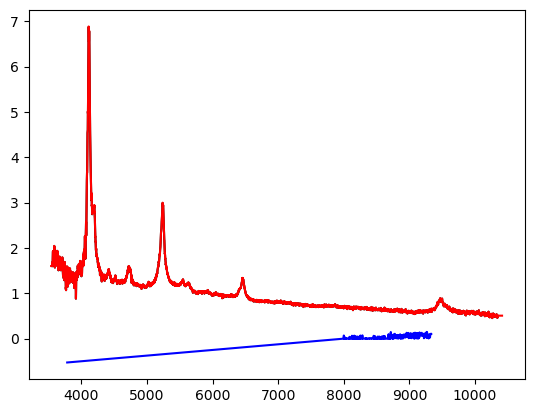

In [2]:
plt.plot(waves[1], fluxes[1], color='black')
plt.plot(wave_obs, spec[1], color='red')
plt.plot(10**np.arange(3.578, 3.97, 0.0001), spec_reco[1], color='blue')
print(spec_reco.shape, spec_rest.shape)

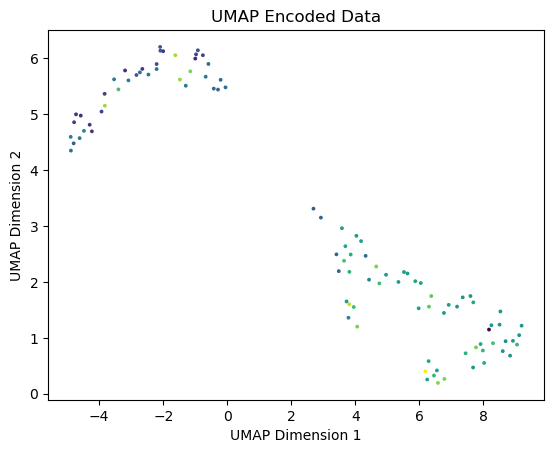

In [19]:
import umap

reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(s)

# Plot the Reduced Data 

umap_x = reduced_data[:, 0]
umap_y = reduced_data[:, 1]

plt.scatter(umap_x, umap_y, s=3, c=z)
plt.title("UMAP Encoded Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

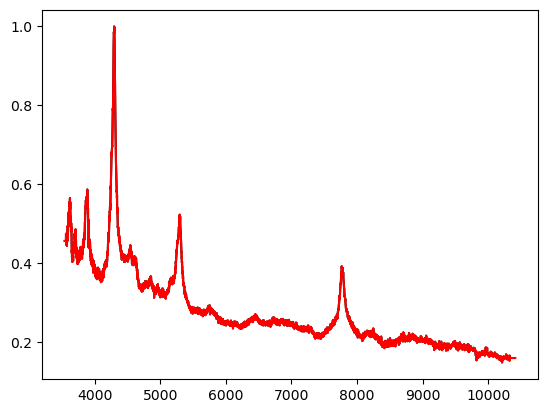

In [31]:
hdulist = fits.open('/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/data/sdss-qso-catalogue/spectra/7595/spec-7595-56957-0005.fits')
data = hdulist[1].data
wave_raw = 10**data["loglam"]
flux = data["model"]

wave_obs = 10 ** np.arange(3.549, 4.0175, 0.0001)

specinfo = hdulist[2].data[0]
z = np.array(specinfo["Z"])

# normalize spectrum:
wave_rest = wave_obs / (1 + z)

wave_raw = 10**data['loglam']
model_flux = data['model']/np.max(data['model'])

spec = np.interp(wave_obs, wave_raw, model_flux)

plt.plot(wave_raw, model_flux, color='black')
plt.plot(wave_obs, spec, color='red')


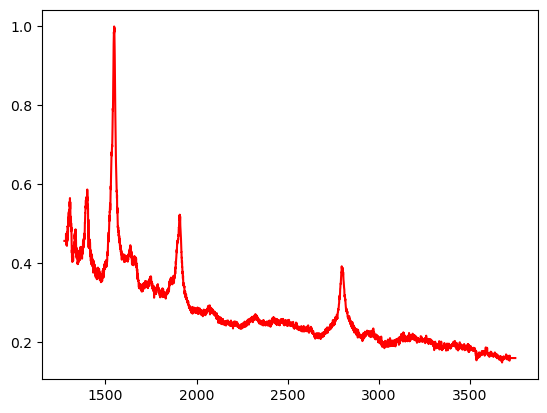

In [33]:
#plt.plot(waves[2], fluxes[2], color='black')
plt.plot(wave_rest, spec, color='red')